# Preprocessing data quality overview
This notebooks allows to inspect preprocessed sessions, one-by-one or in batch, to asses the quailty of the preprocessing by visual inspection and metrics calculation.

Sessions that do not satisfy quality criteria can be discarded or re-preprocessed with a different set of CaImAn parameters that can be selected using [session_overview.ipynb](../session_overview.ipynb)

In [145]:
import os
import sys
sys.path.append(os.path.abspath('../'))

import caiman as cm
import numpy as np
import matplotlib.pyplot as plt
from caiman.source_extraction.cnmf.cnmf import load_CNMF
import pandas as pd
from pathlib import Path
import pickle
import glob
import gc
import seaborn as sns
import utils.data_quality as dq

In [2]:
# Paths and parameters

DATA_PATH = Path("/ceph/imaging1/davide/2p_data_no_luminance_corr")

SESSIONS = {'441394_ribolla':['20230301','20230306','20230307','20230308','20230309',
                              '20230315','20230316','20230317','20230320','20230321',
                              '20230323','20230324','20230328','20230330','20230331',
                              '20230404','20230405','20230406','20230407','20230408',
                              '20230411','20230412','20230413','20230414'],
            
            '441406_fiano': ['20230301','20230306','20230307','20230308','20230309',
                              '20230315','20230316','20230317','20230320','20230321',
                              '20230323','20230324','20230328','20230330','20230331',
                              '20230404','20230405','20230406','20230407','20230408',
                              '20230411','20230412','20230413','20230414']
           }


# RAW VIDEO SUMMARY IMAGES

In [3]:
dq.interactive_summary_images(data_path= DATA_PATH,sessions=SESSIONS)

interactive(children=(Dropdown(description='Animal:', options=('441394_ribolla', '441406_fiano'), value='44139…

# PREPROCESSING RESULTS

In [8]:
animal = '441406_fiano'
session = '20230307'

cnmf_file = DATA_PATH.joinpath(f'{animal}/{session}/cnmf.hdf5')
cnmf = load_CNMF(cnmf_file)
ests = cnmf.estimates

metrics_file = DATA_PATH.joinpath(f'{animal}/{session}/metrics.pickle')
with open(metrics_file,'rb') as pfile:
            metrics = pickle.load(pfile)

print('Not corrected')
print(f'total # of components:{len(ests.idx_components)+len(ests.idx_components_bad)}')
print(f'GOOD components:{len(ests.idx_components)}')
print(f'BAD components:{len(ests.idx_components_bad)}')


Not corrected
total # of components:1311
GOOD components:204
BAD components:1107


count    37628.000000
mean      1861.291138
std       1445.066040
min       -629.713074
25%       1419.179413
50%       1774.077942
75%       2234.421631
max       7068.895996
dtype: float64

<Figure size 2000x1000 with 0 Axes>

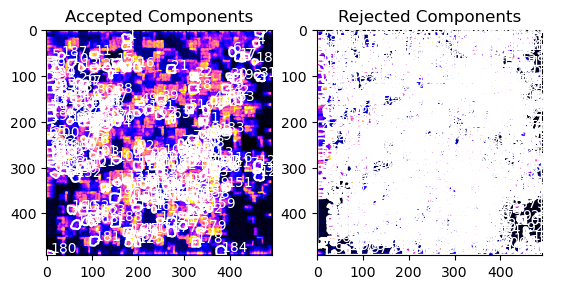

In [19]:
plt.figure(figsize=(20,10))
ests.plot_contours(idx=ests.idx_components,cmap=plt.cm.gnuplot2)


# Batch summary and stats

In [13]:
summary = dq.compute_batch_summary(DATA_PATH,SESSIONS)

File not found for animal '441394_ribolla', date '20230307'
File not found for animal '441394_ribolla', date '20230308'
File not found for animal '441394_ribolla', date '20230328'
File not found for animal '441406_fiano', date '20230308'
File not found for animal '441406_fiano', date '20230405'
File not found for animal '441406_fiano', date '20230406'
File not found for animal '441406_fiano', date '20230407'
File not found for animal '441406_fiano', date '20230408'
File not found for animal '441406_fiano', date '20230411'
File not found for animal '441406_fiano', date '20230412'
File not found for animal '441406_fiano', date '20230413'
File not found for animal '441406_fiano', date '20230414'


In [158]:
summary.head()

,n_neurons,SNR_components,r_values,cnn_preds,pixels_sn,neurons_sn,animal,date
0,152,3.324507,0.709162,0.712944,1171.204956,2231.513496,441394_ribolla,20230301
1,163,2.519592,0.66788,0.578299,938.17041,1802.73417,441394_ribolla,20230306
2,0,NaN,NaN,NaN,NaN,NaN,441394_ribolla,20230309
3,98,1.550477,0.566177,0.83061,2231.40332,3893.816864,441394_ribolla,20230315
4,18,2.613386,0.068939,0.639744,2457.72876,7864.842559,441394_ribolla,20230316


Text(0, 0.5, 'n neurons')

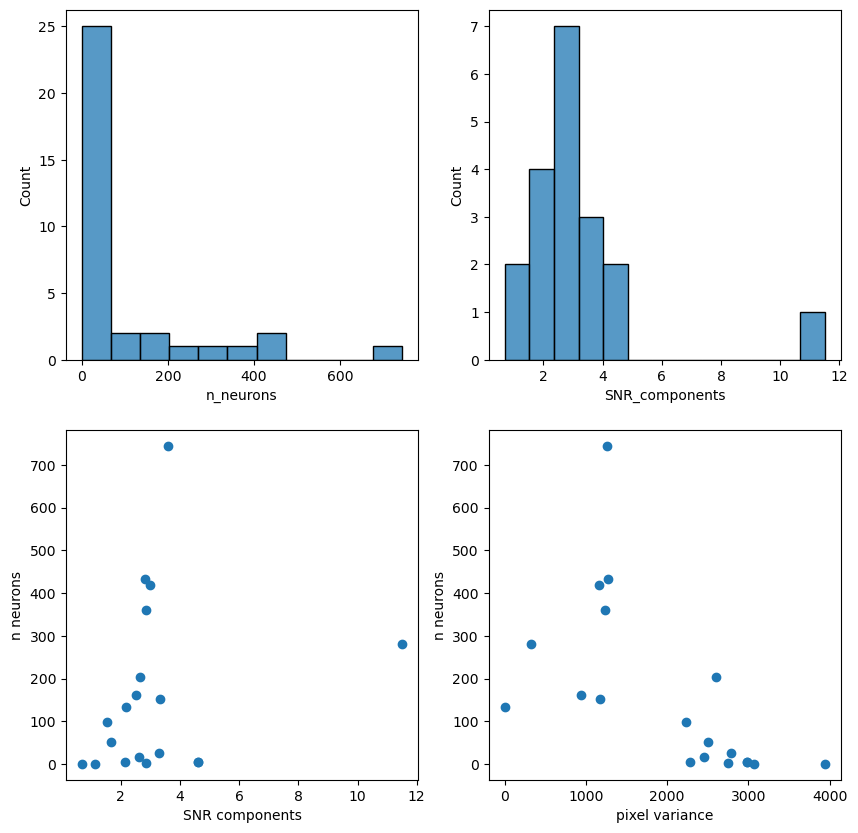

In [160]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.histplot(data=summary,x='n_neurons')

plt.subplot(2,2,2)
sns.histplot(data=summary,x='SNR_components')

plt.subplot(2,2,3)
plt.scatter(summary.SNR_components,summary.n_neurons)
plt.xlabel('SNR components')
plt.ylabel('n neurons')


plt.subplot(2,2,4)
plt.scatter(summary.pixels_sn,summary.n_neurons)
plt.xlabel('pixel variance')
plt.ylabel('n neurons')

# TO DO:
- print footprints
- print traces
- comute firing rate distr and summary
- OTHER METRICS?

In [165]:
animal = '441406_fiano'
date = '20230307'

with open(DATA_PATH.joinpath(f'{animal}/{date}/metrics.pickle'),'rb') as pfile:
            metrics = pickle.load(pfile)
        


cnmf_file = DATA_PATH.joinpath(f'{animal}/{date}/cnmf.hdf5')
cnmf = load_CNMF(cnmf_file)
ests = cnmf.estimates



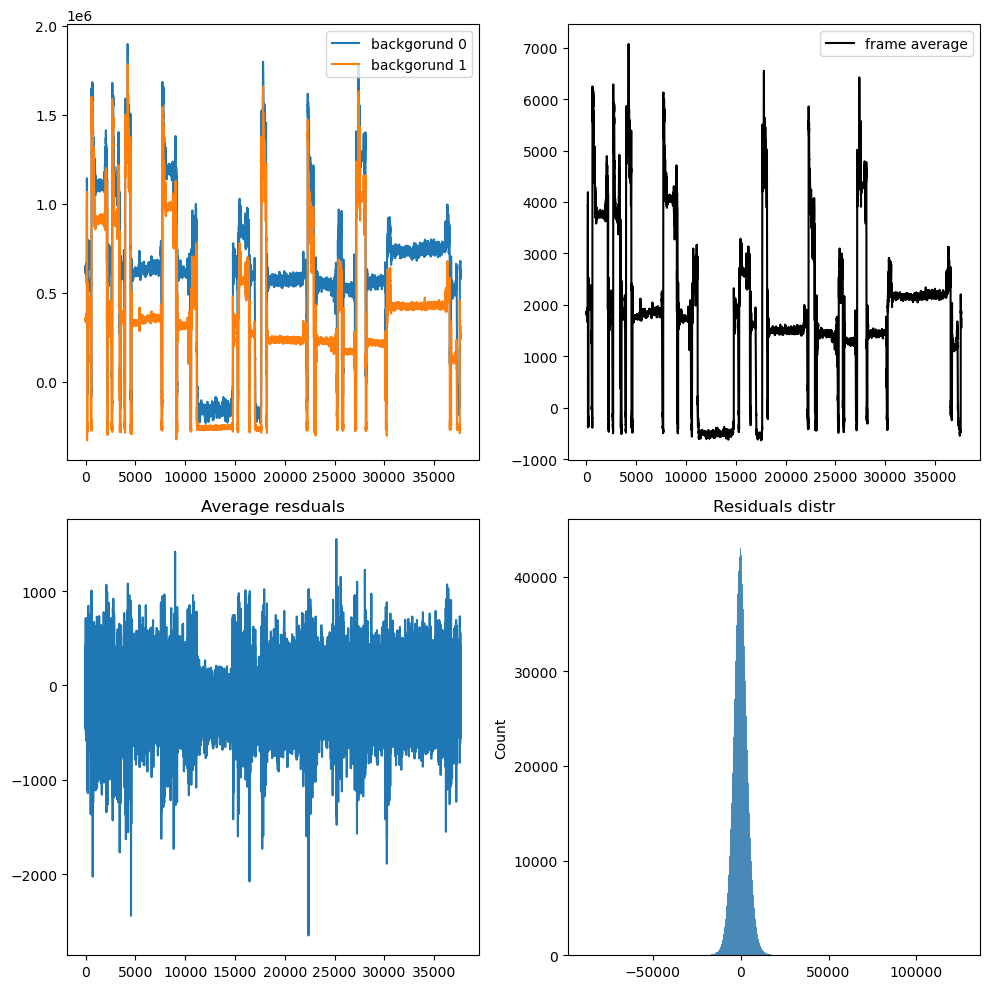

In [175]:
def estimates_visual_summary(estimates,metrics):
    
    plt.figure(figsize=(10,10))
    
    # Background plot
    
    plt.subplot(2,2,1)
    
    for i,bc in enumerate(estimates.f):
        plt.plot(bc,label=f'backgorund {i}')
        plt.legend()

        
    plt.subplot(2,2,2)
        
    x = np.asarray(metrics['frame_average'])
    plt.plot(x,c='k',label='frame average')
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.title('Average resduals')
    good_components = estimates.idx_components
    plt.plot(np.mean(ests.R[good_components],axis=0))
    
    
    
    plt.subplot(2,2,4)
    plt.title('Residuals distr')
    good_components = estimates.idx_components

    sns.histplot(ests.R[good_components].ravel())
    
    plt.tight_layout()


estimates_visual_summary(ests,metrics)